## Логистическая регрессия

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib inline
np.random.seed(7)

## 1. Логистическая регрессия на синтетических данных

Для генерации синтетических данных для задачи бинарной классификации можно воспользоваться функцией [`sklearn.datasets.make_blobs`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html). Сгенерируем данные с двумя признаками (факторами), чтобы их было удобно изобразить на плоскости.

In [2]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=9)

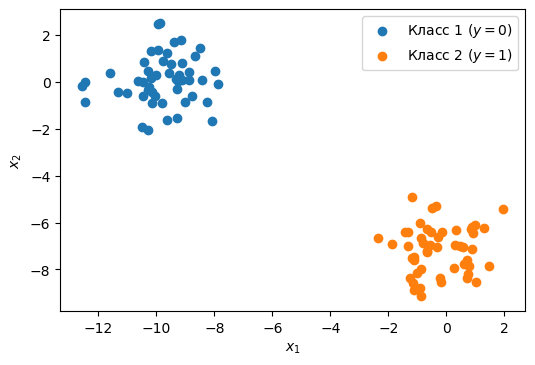

In [4]:
plt.figure(dpi=100)
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Класс 1 ($y = 0$)')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Класс 2 ($y = 1$)')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

Ниже представлена заготовка класса логистической регрессии. Реализуйте недостающие части.

In [102]:
class LogisticRegression:
    '''
    A simple logistic regression for binary classification with gradient descent
    '''
    
    def __init__(self, learning_rate=0.1, max_iter=1000, verbose=False):
        # Learning rate for gradient descent
        self._lr = learning_rate
        # Maximum number of iterations for gradient descent
        self._max_iter = max_iter
        # Show verbose history
        self.verbose = verbose
        # How often to print validation info
        self._validation_freq = 50
        
        
    def fit(self, X, y):
        losses = []
        # Add extra dummy feature (x[-1] = 1) for bias
        X = self.__add_intercept(X)
        y = y.reshape(-1, 1)
        n_objects, n_features = X.shape
        self._weights = np.random.normal(size=(n_features, 1), scale=0.1)
        
        # Iterative gradient descent
        for i in range(self._max_iter):
            '''
            Compute probabilities, gradient, and update weights
            '''
            p = self.__sigmoid(np.dot(X, self._weights))
            grad = self.__gradient_descent(X, p, y)
            self._weights = self._weights - grad * self._lr
            
            # Compute probabilities after weights update
            p = self.__sigmoid(np.dot(X, self._weights))
            
            # Clip values for numeric stability in logarithm
            p = np.clip(p, 1e-10, 1 - 1e-10)
            
            # Compute Negative log-likelihood loss 
            loss = self.__loss(y, p)
            losses.append(loss)

            # Compute accuracy
            acc = np.mean((p >= 0.5) == y)
                
            if self.verbose and i % self._validation_freq == 0:
                print("Iteration {}: Loss = {}. Accuracy = {}".format(i, loss, acc))

        return losses
        
    def predict(self, X, threshold=0.5):
        '''
        Predict class labels for samples in X.
        '''
        X = self.__add_intercept(X)
        #return np.where(self.__sigmoid(np.dot(X, self._weights)) < 
        #                             threshold, 0, 1).flatten().flatten()
        #return (1 * (self.__sigmoid(np.dot(X, self._weights)) >
        #                                          threshold)).flatten()
        predictions = np.where(self.__sigmoid(np.dot(X, self._weights)) >= threshold, 1, 0)
        return np.squeeze(predictions)

    def predict_proba(self, X):
        '''
        Probability estimates.
        '''
        X = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X, self._weights)).flatten()
    
    def __gradient_descent(self, X, p, y):
        return np.dot(X.T, (p - y)) / y.shape[0]
    
    def __add_intercept(self, X):
        return np.hstack([X, np.ones((len(X), 1))])
    
    def __loss(self, y, p):
        '''
        Compute negative log-likelihood loss
        '''
        return (-y * np.log(p) - (1 - y) * np.log(1 - p)).mean()

    def __sigmoid(self, v):
        return 1.0 / (1 + np.exp(-v))

    def __logit(self, x):
        return np.log(x / (1 - x))

Обучите модель на сгенерированных ранее данных.

In [6]:
clf = LogisticRegression(learning_rate=0.1, max_iter=100, verbose=True)
losses = clf.fit(X, y)

Iteration 0: Loss = 0.16294514841166624. Accuracy = 1.0
Iteration 50: Loss = 0.007553621049117038. Accuracy = 1.0


Постройте график, показывающий зависимость значения функции потерь от номера итерации.

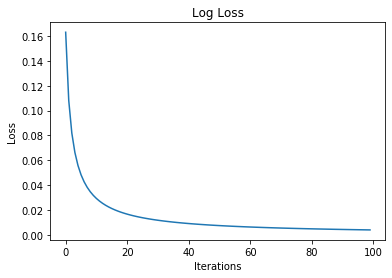

In [7]:
plt.plot(losses)
plt.title("Log Loss");
plt.ylabel('Loss');
plt.xlabel('Iterations');

Постройте график, показывающей форму границы решения (англ. decision boundary).

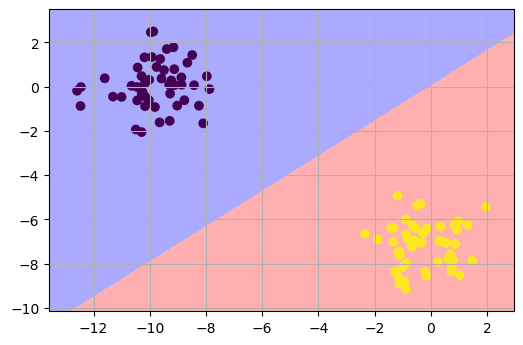

In [8]:
fig = plt.figure(dpi=100)
xx, yy = np.meshgrid(np.linspace(X[:,0].min() - 1, X[:,0].max() + 1, 1000), 
                     np.linspace(X[:,1].min() - 1, X[:,1].max() + 1, 1000))
pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])
pred = pred.reshape(xx.shape)
plt.pcolormesh(xx, yy, pred, cmap=ListedColormap(['#AAAAFF','#FFAFAF']))
plt.grid()
plt.scatter(X[:,0], X[:,1], c=y)

plt.show()

Выпишите уравнение границы решения. 

**Ответ:** $Y = -(\epsilon + \beta{_0}X) / \beta{_1}$

Постройте график получившейся прямой на диаграмме рассеяния.

In [9]:
w0, w1, eps = clf._weights
xx = np.linspace(X[:,0].min() - 1, X[:,0].max() + 1, 100)
yy = -(eps + w0 * xx) / w1

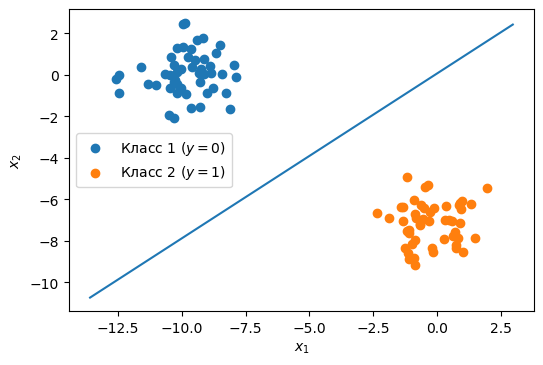

In [10]:
plt.figure(dpi=100)
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Класс 1 ($y = 0$)')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Класс 2 ($y = 1$)')
plt.plot(xx, yy)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

Постройте ROC-кривую для получившейся модели. Вычислите значение AUC.

In [11]:
def plot_roc_auc(fpr, tpr, roc_auc):
    plt.figure(dpi=100)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

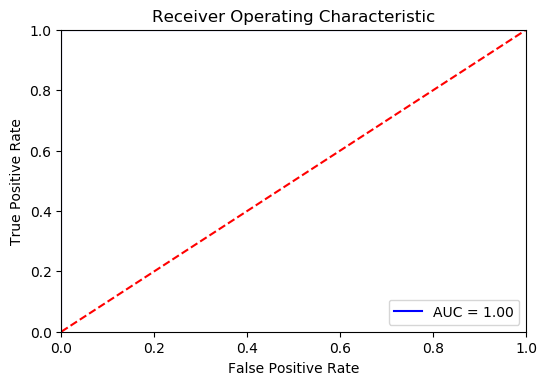

In [12]:
probs = clf.predict_proba(X)
fpr, tpr, threshold = metrics.roc_curve(y, probs)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_auc(fpr, tpr, roc_auc)

Как можно объяснить полученный вид кривой и значение AUC?

**Ответ:** Площадь под ROC-кривой равна 1 — доле всех правильных ответов.

Постройте диаграмму рассеяния и обучите модель логистической регресси для данных, сгенерированных ниже.

In [13]:
X, y = make_blobs(n_samples=100, n_features=2, centers=[[1, 2], [2, 3]])

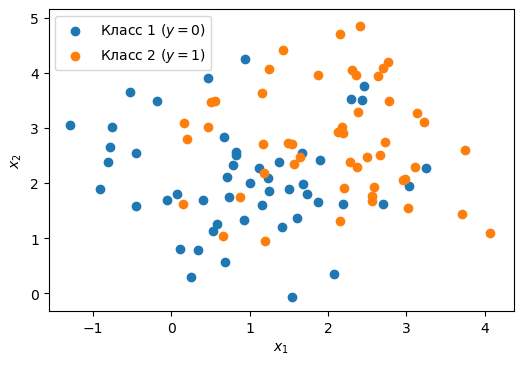

In [14]:
plt.figure(dpi=100)
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Класс 1 ($y = 0$)')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Класс 2 ($y = 1$)')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

In [15]:
clf = LogisticRegression(learning_rate=0.1, max_iter=100, verbose=True)
losses = clf.fit(X, y)

Iteration 0: Loss = 0.6976389830908285. Accuracy = 0.51
Iteration 50: Loss = 0.6006010386469383. Accuracy = 0.68


Реализуйте функции `roc_curve(y, probs)` и `auc(fpr, tpr)`. Первая функция по меткам классов `y` и вероятностям `probs`, выданным логистической регрессией, должна вычислять массывы значений TPR (True Positives Rate) и FPR (False Positives Rate) для разных значений порога (и возвращает полученные значения TPR, FPR и thresholds). Вторая функция должна вычислять значение AUC (Area Under Curve) для кривой, заданной точками `fpr` и `tpr`. При реализации нельзя использовать сторонние библиотеки (за исключением NumPy).

In [16]:
def roc_curve(y, probs):
  
    #thresholds = np.arange(max(probs), 0, -0.012)
    #thresholds = np.insert(thresholds, 0, max(thresholds) + 1, axis=0)
    size = int(len(y) * 0.4) - 2
    thresholds = np.linspace(np.median(probs) / 2, max(probs), 
                                           int(len(y) / 2))[::-1][:size]
    thresholds = np.insert(thresholds, 0, max(probs) + 1, axis=0)
    thresholds = np.insert(thresholds, len(thresholds), min(probs), axis=0)

    # false positive rate
    fpr = np.zeros(thresholds.shape[0])
    # true positive rate
    tpr = np.zeros(thresholds.shape[0])

    # get number of positive and negative examples in the dataset
    P = np.sum(y)
    N = len(y) - P

    # iterate through all thresholds and determine fraction of true positives
    # and false positives found at this threshold
    for num, thresh in enumerate(thresholds):
        FP, FN = 0, 0
        TP, TN = 0, 0
        for i in range(len(probs)):
            if probs[i] >= thresh:
                if y[i] == 1:
                    TP += 1
                else: #if y[i] == 0:
                    FP += 1
            else:
                if y[i] == 0:
                    TN += 1
                else:
                    FN += 1
        #Sp = TN / (TN + FP)
        fpr[num] = FP / (FP + TN) # 1 - Sp
        tpr[num] = TP / (TP + FN)
    return fpr, tpr, thresholds

def auc(fpr, tpr):
    yy = (tpr[1:] + tpr[:-1]) / 2
    xx = np.diff(fpr)
    return np.sum(yy * xx)

In [17]:
roc_curve(y, probs)

(array([0.  , 0.02, 0.46, 0.46, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48,
        0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48,
        0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48,
        0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 1.  ]),
 array([0.  , 0.  , 0.5 , 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52,
        0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52,
        0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52,
        0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 1.  ]),
 array([1.99953929e+00, 9.99539291e-01, 9.84170661e-01, 9.68802031e-01,
        9.53433400e-01, 9.38064770e-01, 9.22696139e-01, 9.07327509e-01,
        8.91958879e-01, 8.76590248e-01, 8.61221618e-01, 8.45852988e-01,
        8.30484357e-01, 8.15115727e-01, 7.99747096e-01, 7.84378466e-01,
        7.69009836e-01, 7.53641205e-01, 7.38272575e-01, 7.22903944e-01,
        7.07535314e-01, 6.92166684e-01, 6.76798053e-01, 6.61429423e-01,
        6.46060793e-

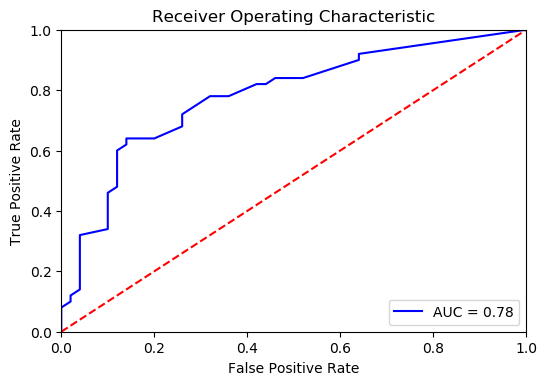

In [18]:
probs = clf.predict_proba(X)
fpr, tpr, threshold = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)
plot_roc_auc(fpr, tpr, roc_auc)

In [19]:
probs = clf.predict_proba(X)

Проверьте правильность работы своих функций, сравнив полученную кривую и значение AUC, с аналогичными значеними, рассчитанными с помощью библиотеки `sklearn`.

In [20]:
fpr, tpr, threshold = metrics.roc_curve(y, probs)
metrics.auc(fpr, tpr)

0.7904000000000001

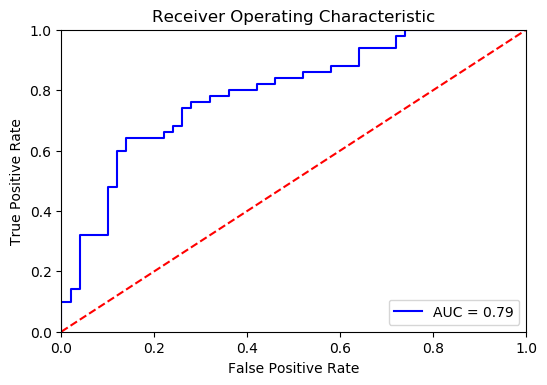

In [21]:
preds = clf.predict_proba(X)
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_auc(fpr, tpr, roc_auc)

## 2. Логистическая регрессия на реальных данных

Во второй части вам нужно построить модель логистической регрессии, позволяющую предсказать, есть ли у пациента диабет II типа, по набору результатов обследований. Для построения модели предлагается использовать данные [Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database), которые содержат данные обследований 768 пациенток индийской народности Пима. В данных содержатся следующие показатели.


1. Число беременностей (Pregnancies).
2. Концентрация глюкозы в плазме через 2 часа после введения в пероральном глюкозотолерантном тесте (Glucose).
3. Диастолическое артериальное давление [мм рт. ст.] (BloodPressure).
4. Толщина кожной складки в районе трицепса [мм] (SkinThickness).
5. Концентрация инсулина в сыворотке крови [мкЕд/мл] (Insulin).
6. Индекс массы тела [вес в кг/(рост в м)^2] (BMI).
7. Функция, описывающая генетическую предрасположенность к диабету (DiabetesPedigreeFunction).
8. Возраст [годы] (Age).

Outcome -- страдает ли пациент сахарным диабетом. Если страдает Outcome = 1, в противном случае Outcome = 0.



In [22]:
df = pd.read_csv('http://edu.std-900.ist.mospolytech.ru/files/diabetes.csv')
print(df.shape)

(768, 9)


In [23]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Разделите данные на обучающую и тестовую выборки в пропорции 70% на 30% соответственно с помощью функции [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Обратите внимание на параметр `stratify`.

In [25]:
counts = df.Outcome.value_counts()
print("Is this a balanced dataset? {}".format(counts[1] == counts[0]))

Is this a balanced dataset? False


In [26]:
X = df.drop('Outcome', axis=1)
y = df.Outcome

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(537, 8) (231, 8) (537,) (231,)


Проведите [стандартизацию](https://wiki.loginom.ru/articles/data-standartization.html) данных, чтобы привести признаки к одному масштабу. В дальнейшем это позволит сравнивать коэффициенты регрессии при разных признаках.

*Подсказка: среднее значение и стандартное отклонение нужно вычислять по обучающей выборке.*

In [28]:
mu = X_train.mean()
sigma = X_train.std()

In [29]:
X_train_normalized = (X_train - mu) / sigma
X_test_normalized = (X_test - mu) / sigma

Обучите на подготовленных данных модель логистической регрессии. Экспериментальным путём подберите оптимальное значение `learning_rate`.

In [103]:
rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
losses_ = []
for r in rates:
    clf = LogisticRegression(learning_rate=r, max_iter=1000, verbose=False)
    los = clf.fit(X_train.values, y_train.values)
    losses_.append((np.mean(np.mean(los))))

/Users/popov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: overflow encountered in exp


In [104]:
losses_

[2.2696333446735877,
 8.264419608315249,
 9.331833924921975,
 9.535915292801855,
 9.56194476841444,
 9.59167758418307,
 9.541034256999458,
 9.603289175142981]

Постройте график, показывающий зависимость значения функции потерь от номера итерации.

In [105]:
clf = LogisticRegression(learning_rate=rates[0], max_iter=100, verbose=True)
losses = clf.fit(X_train.values, y_train.values)

Iteration 0: Loss = 1.6431403496975738. Accuracy = 0.6033519553072626
Iteration 50: Loss = 4.1661333917248475. Accuracy = 0.6517690875232774


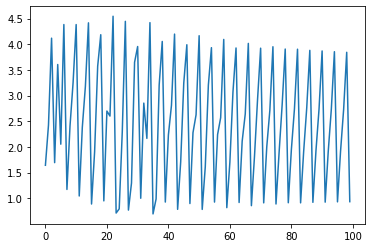

In [106]:
plt.plot(losses)

Вычислите значения accuracy, precision, recall для тестовой выборки. Можно воспользоваться функциями `accuracy_score`, `precision_score`, `recall_score` модуля [`sklearn.metrics`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score).

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [108]:
accuracy_score(clf.predict(X_test.values), y_test.values)

0.6363636363636364

In [109]:
precision_score(clf.predict(X_test.values), y_test.values)

0.7283950617283951

In [110]:
recall_score(clf.predict(X_test.values), y_test.values)

0.48760330578512395

In [111]:
f1_score(clf.predict(X_test.values), y_test.values)

0.5841584158415841

Постройте ROC-кривую и вычислите значение AUC.

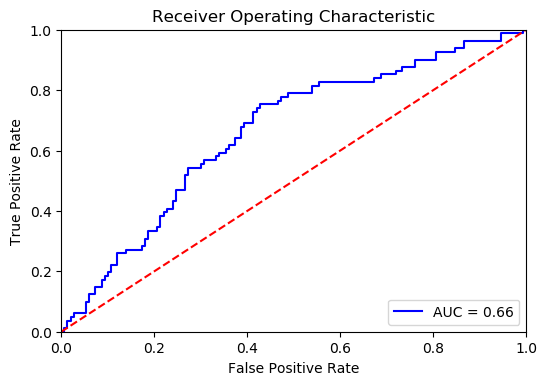

In [107]:
preds = clf.predict_proba(X_test.values)
fpr, tpr, threshold = metrics.roc_curve(y_test.values, preds)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_auc(fpr, tpr, roc_auc)

Один из способов определить оптимальное значение порога для классификации -- это [индекс Юдена](https://en.wikipedia.org/wiki/Youden%27s_J_statistic). Реализуйте функцию `youdens_j_threshold`, которая имеет 3 параметра: `fpr`,`tpr`,`thresholds` -- значения, возвращаемые функцией `roc_curve`, и возвращает оптимальное значение порога. 

Подсказка: можно использовать функцию `np.argmax`. Подробнее о индексе Юдена можно прочитать в [презентации](http://edu.std-900.ist.mospolytech.ru/presentations/logistic-regression).

In [46]:
def youdens_j_threshold(fpr, tpr, thresholds):
    j = thresholds[np.argmax(tpr - fpr)]
    return j

In [113]:
youdens_j_threshold(*metrics.roc_curve(y_test.values, preds))

0.4949655913556094

Используйте полученное в предыдущем задании значение порога в функции `predict`. Как изменятся значения accuracy, precision, recall при новом значении порога?

In [114]:
accuracy_score(clf.predict(X_test.values, threshold=0.494), y_test.values)

0.6363636363636364

In [115]:
precision_score(clf.predict(X_test.values, threshold=0.494), y_test.values)

0.7530864197530864

In [116]:
recall_score(clf.predict(X_test.values, threshold=0.494), y_test.values)

0.488

Для диагностических тестов используются такие показатели как чувствительность (англ. sensitivity) -- вероятность того, что тест
окажется позитивным при наличии признака $\left (\frac{TP}{TP+FN} \right )$, и специфичность (англ. specificity) -- вероятность того, что тест окажется негативным при отсутствии признака $\left (\frac{TN}{TN+FP} \right )$. Вычислите [чувствительность и специфичность](https://ru.wikipedia.org/wiki/%D0%A7%D1%83%D0%B2%D1%81%D1%82%D0%B2%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C_%D0%B8_%D1%81%D0%BF%D0%B5%D1%86%D0%B8%D1%84%D0%B8%D1%87%D0%BD%D0%BE%D1%81%D1%82%D1%8C) для обученной логистической регрессии. Какое значение порога является более предпочтительным с точки зрения этих показателей: значение по умолчанию 0,5 или значение, полученное при помощи индекса Юдена? 

In [51]:
def sens_spec(y_test, predictions):
    TP = FP = TN = FN = 0
    for i in range(len(y_test)):
        TP += y_test[i] == predictions[i] == 1
        TN += y_test[i] == predictions[i] == 0
        FP += y_test[i] == 0 and predictions[i] == 1
        FN += y_test[i] == 1 and predictions[i] == 0
    return TP / (TP + FN), TN / (TN + FP) # sensitivity, specificity

In [117]:
predicts = clf.predict(X_test.values, threshold=0.5)

In [118]:
sens_spec(y_test.values, predicts)

(0.7283950617283951, 0.5866666666666667)

In [119]:
predicts = clf.predict(X_test.values, threshold=0.494)

In [120]:
sens_spec(y_test.values, predicts)

(0.7530864197530864, 0.5733333333333334)

**Ответ:** Чуствительность модели 0.73 при значении трешхолда 0.5, специфичность — 0.59. При трешхолде равном 0.494, полученном по результатам теста Юдена, чувствительность увеличивается, при незначительном уменьшении показателя специфичности.

Выведите полученные значения коэффициентов регрессии для каждого признака.

In [121]:
clf._weights[:-1]

array([[-0.00175451],
       [ 0.04408776],
       [-0.08622449],
       [ 0.00157762],
       [ 0.01067776],
       [-0.05258252],
       [-0.05824581],
       [ 0.05443306]])

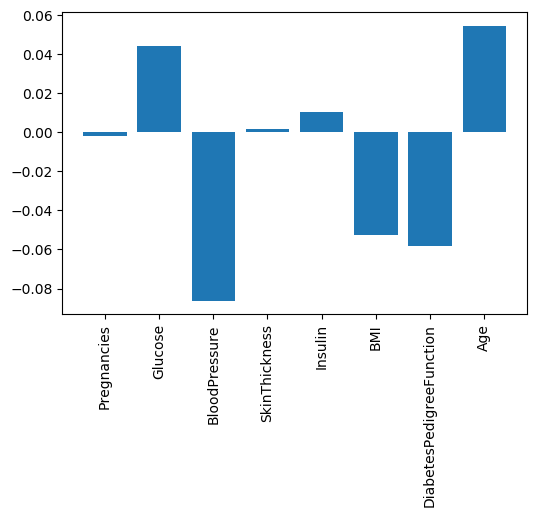

In [122]:
fig = plt.figure(dpi=100)
plt.bar(df.columns[:-1], clf._weights[:-1].squeeze())
plt.xticks(rotation=90)
plt.show()

На основе анализа полученных данных определите, какие признаки являются наиболее значимыми (информативными) для диагностирования у пациента диабета II типа.

**Ответ:** На основе анализа модели можно выделить три особенно значимых признака: 
 1. концентрация глюкозы в плазме *;
 2. концентрация инсулина в сыворотке;
 3. возраст пациента *.



### Полезные материалы
1. [Материалы по логистической регрессии курса по машинному обучению от МФТИ](https://github.com/ml-mipt/ml-mipt/tree/master/week0_03_logistic)
2. [Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database)
3. [Обсуждение методов вычисления оптимального порога для ROC-кривой на StackOverflow](https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python)